# Time Series Forcasting

##  Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Read a CSV file located, set the 'Date' column as the index, and parse the 'Date' column as datetime objects.**


In [2]:
df = pd.read_csv('../ex/monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS' 

In [3]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


## Create a line plot for the entire DataFrame

<Axes: xlabel='Date'>

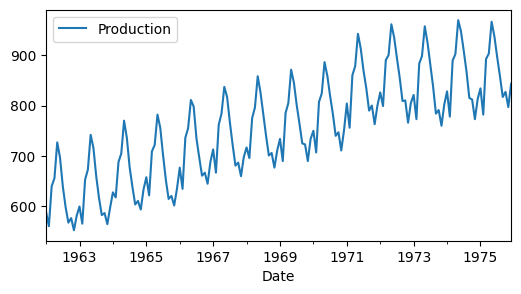

In [4]:
df.plot(figsize=(6,3))

## Model Imported for performing seasonal decomposition of time series data.

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

## Perform seasonal decomposition on the 'Production' column of the DataFrame

**Plot the seasonal decomposition results.**

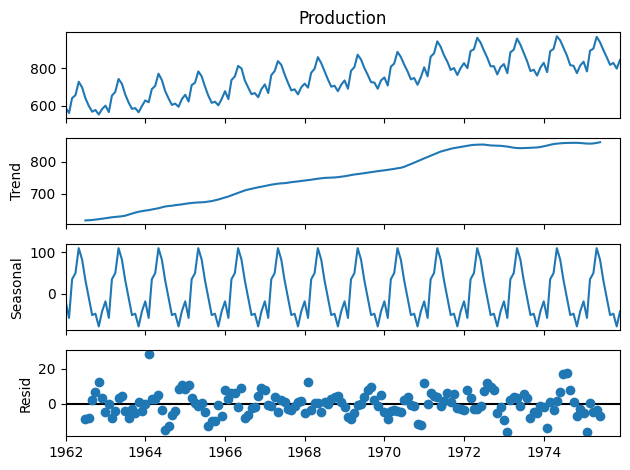

In [6]:
results = seasonal_decompose(df['Production'])
results.plot();

In [7]:
len(df)


168

## Splitting of the data as Train and Test

In [8]:
train = df.iloc[:156]
test = df.iloc[156:]

## Feature Scaling [Feature Engineering]

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [10]:
scaled_train[:10]    

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

## Module import which is used for generating batches of timeseries data.



In [11]:
from keras.preprocessing.sequence import TimeseriesGenerator


## Define Generator

In [12]:
n_input = 12 #No of inputs like months in this case.
n_features = 1 #no of features
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

## Unpack the first batch of data generated.

In [13]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462 0.24759615 0.41826923 0.34615385
 0.20913462 0.11057692 0.03605769 0.05769231 0.         0.06971154]
Predict this y: 
 [[0.11298077]]


In [14]:
X.shape

(1, 12, 1)

## Modules importing for RNN and LSTM

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## Define LSTM model with 100 Neurons in list layer with relu activation and complied with Adam Optimizer and Mean Squared error as loss function.

In [16]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Fit Model with 30 epochs

In [29]:
model.fit(generator,epochs=30)

Epoch 1/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0030
Epoch 2/30
144/144 [==============================] - 1s 5ms/step - loss: 0.0019
Epoch 3/30
144/144 [==============================] - 1s 5ms/step - loss: 0.0019
Epoch 4/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0019
Epoch 5/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0023
Epoch 6/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0020
Epoch 7/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0020
Epoch 8/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0022
Epoch 9/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0017
Epoch 10/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0027
Epoch 11/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0023
Epoch 12/30
144/144 [==============================] - 1s 6ms/step - loss: 0.0019
Epoch 13/30
144/144 [====

## Line plot to state loss per epoch 

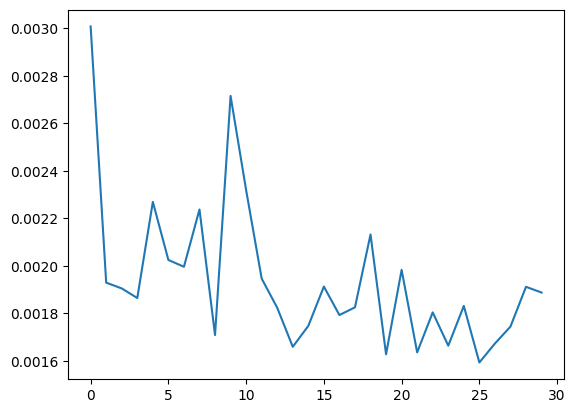

In [30]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Extract the last 12 elements from the scaled_train array and store them in the new variable

In [31]:
last_train_batch = scaled_train[-12:]

## Reshape array equal to the input of Model input

In [32]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

## Predictions

In [33]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 31ms/step


array([[0.6592121]], dtype=float32)

## Continuous Prediction 

In [34]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
     

1/1 [==============================] - 0s 18ms/step


In [35]:
test_predictions # List of Predicitons

[array([0.6592121], dtype=float32),
 array([0.5977439], dtype=float32),
 array([0.8111463], dtype=float32),
 array([0.8638471], dtype=float32),
 array([0.9917489], dtype=float32),
 array([0.9654096], dtype=float32),
 array([0.88786745], dtype=float32),
 array([0.78421843], dtype=float32),
 array([0.65717626], dtype=float32),
 array([0.6227614], dtype=float32),
 array([0.5542962], dtype=float32),
 array([0.6084278], dtype=float32)]

In [36]:
test.head()

,Production,Predictions
Date,,
1975-01-01,834,834.480122
1975-02-01,782,821.688850
1975-03-01,892,906.822227
1975-04-01,903,936.357698
1975-05-01,966,983.794601


## Inverser scaling to get correct predicted value

In [37]:
true_predictions = scaler.inverse_transform(test_predictions)

## Storing true predcitions in test dataset

In [38]:
test['Predictions'] = true_predictions
pd.options.mode.copy_on_write = True 

## Plotting Actual vs Predicted line Graph

<Axes: xlabel='Date'>

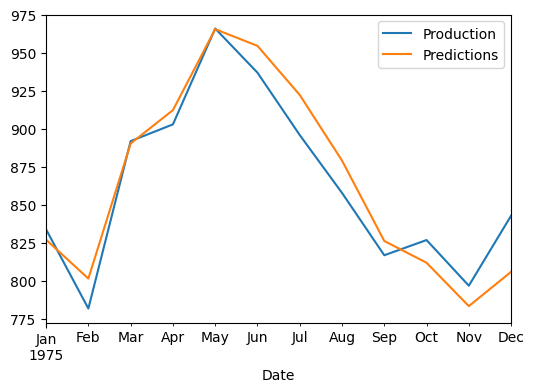

In [39]:
test.plot(figsize=(6,4))

## Calculating Mean Squared Error for comparision

In [40]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

17.865796013327877
